In [2]:
from ipywidgets import interact
from fastai.basics import *

plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: 
        plt.title(title)

In [3]:
from numpy.random import normal, seed, uniform
np.random.seed(42)

class Quad:
    """A quadratic function of the form ax^2 + bx + c."""
    def __init__(self, a: float, b: float, c: float):
        self.a, self.b, self.c = a, b, c

    def __str__(self): return f'${self.a:.2f}x^2 + {self.b:.2f}x + {self.c:.2f}$'
    def __repr__(self): return f'Quad({self.a}, {self.b}, {self.c})'
    def __call__(self, x): return self.a * x**2 + self.b * x + self.c
    def as_latex(self): return self.__str__()
    def plot(self, ylim=None, title=None):
        title = self.as_latex() if not title else title
        plot_function(self, title, ylim=ylim)

    def noise(self, x, scale): 
        return normal(scale=scale, size=x.shape)
    def add_noise(self, x, mult, add):
        return Tensor(x * (1 + self.noise(x, mult)) + self.noise(x, add))

    def get_noisy_y(self, mult=0.3, add=1.5, min=-2, max=2, steps=20):
        x = torch.linspace(min, max, steps)[:, None]
        return (x,self.add_noise(self(x), mult, add))
    
    def scatter_noise(self, mult=0.3, add=1.5, min=-2, max=2, steps=20):
        plt.scatter(*self.get_noisy_y(mult, add, min, max, steps))

    def get_x(self, min=-2, max=2, steps=20):
        return torch.linspace(min, max, steps)[:, None]

    def get_y(self, x, mult=0.3, add=1.5):
        return self.add_noise(self(x), mult, add)

    def get_x_y(self, mult=0.3, add=1.5, min=-2, max=2, steps=20):
        x = self.get_x(min, max, steps)
        return x, self.add_noise(self(x), mult, add)
    

In [4]:
np.random.seed(42)
def noise(x, scale):
    """Adds random Gaussian noise to input data.
    
    Args:
        x: Input tensor/array to add noise to (only used for shape)
        scale: Standard deviation of the Gaussian noise
        
    Returns:
        Tensor of Gaussian noise with same shape as input x and standard deviation of scale"""
    return normal(scale=scale, size=x.shape)

def add_noise(x, mult, add):
    """Adds noise to input data.
    
    Args:
        x: Input tensor/array to add noise to
        mult: Multiplier for the Gaussian noise
    """
    return x * (1 + noise(x, mult)) + noise(x, add)

/tmp/ipykernel_799/475098338.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return x * (1 + noise(x, mult)) + noise(x, add)


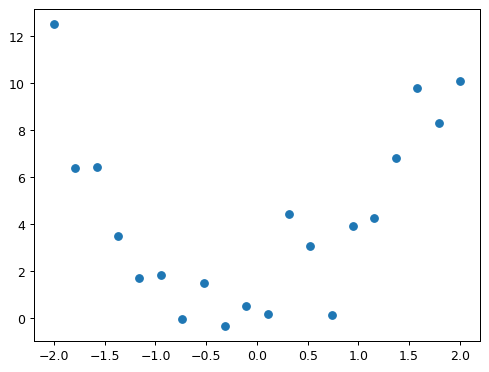

In [5]:

q = Quad(3, 2, 1)
x = torch.linspace(-2, 2, steps=20)[:, None]
y = add_noise(q(x), 0.3, 1.5)
plt.scatter(x, y)


In [6]:
from ipywidgets import interact

@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a, b, c):
    q = Quad(a, b, c)
    plt.scatter(x, y)
    q.plot(ylim=(-3,12))


interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [7]:
# You wouldn't actually use this, but it's a good way to understand the math
# This is what mse does just written out
# Also, you're not dependent on having a numpy array object
def mse(predictions, actuals):
    total = sum( (p - a) ** 2 for p, a in zip(predictions, actuals) )
    return total / len(predictions)

def mse_ol(predictions, actuals):
    """one-liner version of mse"""
    return ((predictions - actuals) ** 2).mean()



## Mean Squared Error
Mean Squared Error is a kind of loss function to tell how well you are approximating a given set of data.

You have all the points described by your curve (coefficients) and all the actual points. So for every x, you take the difference between your prediction for y and the actual value of y. You then square it to eliminate negative values. Finally, you sum all of them up.
# The formula for MSE is:
# $MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$
# 
# where:
# - $n$ is the number of data points
# - $y_i$ is the actual value
# - $\hat{y}_i$ is the predicted value

So given [1, 3, 5], [2, 4, 6]

```
[1  [2,  -> 1^2 = 1
 3,  4,  -> 1^2 = 1
 5]  6]  -> 1^2 = 1

[1+1+1 = 3] / len(preds) = 1
```

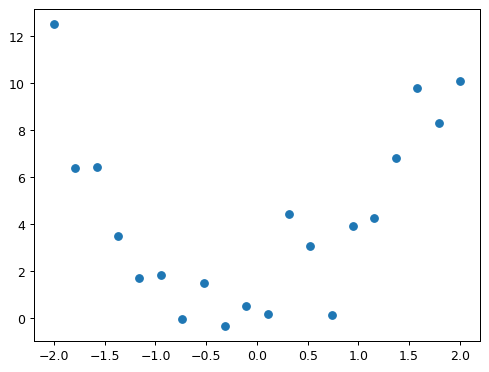

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [8]:
@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a, b, c):
    q = Quad(a, b, c)
    plt.scatter(x, y)
    loss = mse(q(x), y)
    q.plot(ylim=(-3,12), title=f'MSE: {loss:.4f}')
    

In [9]:
quad = Quad(3, 2, 1)
x, y = quad.get_x_y()
def quad_mse(params):
    quad = Quad(*params)

    # Assumes you have a set of x and y values outside of this function.
    # Or you can make one. I'm going to make one.
    return mse(quad(x), y)

/tmp/ipykernel_799/197640576.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return Tensor(x * (1 + self.noise(x, mult)) + self.noise(x, add))


In [10]:

abc = torch.tensor([1.5, 1.5, 1.5], requires_grad=True)
loss = quad_mse(abc)
# Compute gradients
loss.backward()


In [11]:
abc.grad

tensor([-10.9887,  -2.1225,  -4.0015])

In [12]:
with torch.no_grad():
    # For each item in the gradient tensor, reduce is by a factor of alpha
    abc -= abc.grad * 0.01
    loss = quad_mse(abc)

print(f"Loss: {loss.item()}")

Loss: 10.114381219621027


In [13]:
# Let's do the whole thing
# Here's our actual function
quad = Quad(3, 2, 1)
# Let's get some points that are close to the actual function
x, y = quad.get_x_y()
# Let's take some random-ass guesses
abc = torch.tensor([1.5, 1.5, 1.5], requires_grad=True)
# Calculate the loss
loss = quad_mse(abc)
print(f"initial loss: {loss.item()}")
# Calculate the gradients
loss.backward()

# Do one round of gradient descent
# Don't want to calculate gradiets here, since we're just updating values
with torch.no_grad():
    # Update the tensor by a factor of the gradient
    abc -= abc.grad * 0.01
    # This is our new loss
    loss = quad_mse(abc)
    print(f"loss after step: {loss.item()}")




initial loss: 9.284177971301235
loss after step: 8.273777989084703


/tmp/ipykernel_799/197640576.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return Tensor(x * (1 + self.noise(x, mult)) + self.noise(x, add))


# The Whole Thing
1. We want a bunch of points to try to fit a function to
2. We'll define a function `quad` as a template for creating some noisy data
3. We'll create even steps for the x axis, and noisy values for the y axis
4. We'll define a tensor of guesses (requiring it to track gradients)

We'll then do the following in a loop
1. Calculate the loss between our guesses for the coefficients to the function that fits the curve, and the actual values we randomly generated
2. We'll call `backward()` to compute the actual gradients going back through the calculations
3. We'll update all of our guesses by a small negative fraction of the computed gradient
4. I've added code to abort if we start going off in the wrong direction again, but you could also just do a fixed number of iterations

In [14]:
quad = Quad(3, 2, 1)
# Let's get some points that are close to the actual function
x, y = quad.get_x_y()
# Let's take some random-ass guesses
abc = torch.tensor([1.5, 1.5, 1.5], requires_grad=True)

prev_loss = 999999

for i in range(100):
    loss = quad_mse(abc)
    loss.backward()
    with torch.no_grad():
        abc -= abc.grad * 0.001
        loss = quad_mse(abc)
    if loss > prev_loss:
        print(f"Loss went from {prev_loss.item()} to {loss.item()} after step {i+1}")
        break
    prev_loss = loss
    print(f"loss after step {i+1}: {loss.item()}")


loss after step 1: 9.314658065813955
loss after step 2: 9.108640333125885
loss after step 3: 8.808859884600885
loss after step 4: 8.426043614692398
loss after step 5: 7.97388016671228
loss after step 6: 7.468533881594171
loss after step 7: 6.9280600685991285
loss after step 8: 6.3717590691171475
loss after step 9: 5.819476152666075
loss after step 10: 5.2908941535009
loss after step 11: 4.804816176781339
loss after step 12: 4.378498723481026
loss after step 13: 4.027026199193541
loss after step 14: 3.7627702503517475
loss after step 15: 3.5949432503866334
loss after step 16: 3.529270423371672
Loss went from 3.529270423371672 to 3.5677840713061912 after step 17


/tmp/ipykernel_799/197640576.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return Tensor(x * (1 + self.noise(x, mult)) + self.noise(x, add))


/tmp/ipykernel_799/475098338.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return x * (1 + noise(x, mult)) + noise(x, add)


loss after step 1: 8.413198700898013
loss after step 2: 6.753192614341925
loss after step 3: 5.020532183003711
loss after step 4: 3.819716470899833
loss after step 5: 3.5657132973981973
Loss went from 3.5657132973981973 to 4.337907275912768 after step 6
tensor([[12.5396],
        [ 6.3975],
        [ 6.4566],
        [ 3.5170],
        [ 1.6997],
        [ 1.8379],
        [-0.0241],
        [ 1.5212],
        [-0.3274],
        [ 0.5191],
        [ 0.1683],
        [ 4.4394],
        [ 3.0727],
        [ 0.1612],
        [ 3.9298],
        [ 4.2689],
        [ 6.8255],
        [ 9.7947],
        [ 8.3291],
        [10.0925]], dtype=torch.float64)


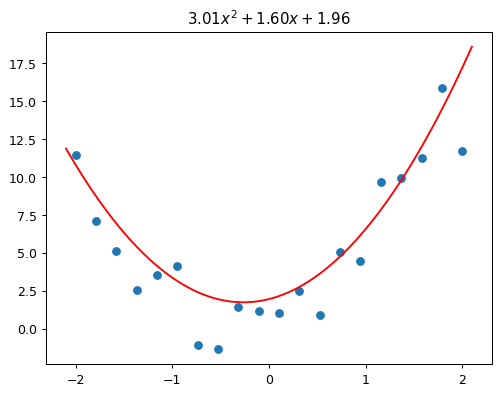

In [15]:
from pprint import pprint as pp;

# Another version
def get_data(a, b, c, min=-2, max=2, steps=20, mult=0.3, add=1.5):
    """Get's some random data given a true quadratic function"""
    np.random.seed(42)
    x = torch.linspace(min, max, steps)[:, None]
    y = add_noise(a * x**2 + b * x + c, mult, add)
    return x, y

def fit(x, y):
    """
    Given a set of x and y values, fit a quadratic function to the data.
    Return the coefficients of the quardratic
    """
    abc = torch.tensor([1.5, 1.5, 1.5], requires_grad=True)
        
    prev_loss = 999999

    for i in range(100):
        loss = quad_mse(abc)
        loss.backward()
        with torch.no_grad():
            abc -= abc.grad * 0.01
            loss = quad_mse(abc)
        if loss > prev_loss:
            print(f"Loss went from {prev_loss.item()} to {loss.item()} after step {i+1}")
            break
        prev_loss = loss
        print(f"loss after step {i+1}: {loss.item()}")
    return abc

data = get_data(3, 2, 1)
best_fit = fit(*data)
best_fit = list(best_fit.detach())

pp(data[1])
quad = Quad(*list(best_fit))
quad.plot()
plt.scatter(x, y)


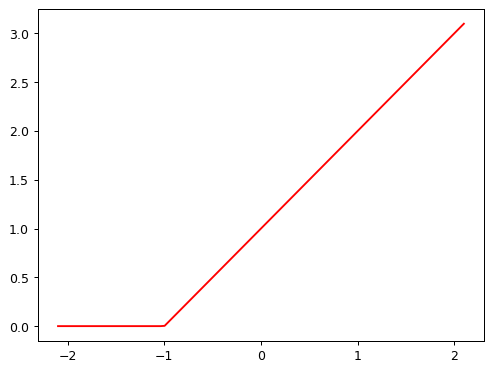

In [16]:
# So wtf are we actually solving for?
# It's not a quadratic, since that's not interesting.
# Let's look at relus

def relu(m, b, x):
    y = (m * x) + b
    return torch.clip(y, 0.)

# This models a relu of y = 1x + 1
# with negative values clipped to zero
plot_function(partial(relu, x=1, b=1))

In [17]:
@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plot_function(partial(relu, m, b), ylim=(-1, 4))


interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [18]:
def double_relu(m1, b1, m2, b2, x):
    return relu(m1, b1, x) + relu(m2, b2, x)

@interact(m1=1.5, b1=1.5, m2=1.5, b2=1.5)
def plot_double_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1, b1, m2, b2), ylim=(-1, 4))




interactive(children=(FloatSlider(value=1.5, description='m1', max=4.5, min=-1.5), FloatSlider(value=1.5, desc…

In [19]:
def triple_relu(m1, b1, m2, b2, m3, b3, x):
    return relu(m1, b1, x) + relu(m2, b2, x) + relu(m3, b3, x)

@interact(m1=1.5, b1=1.5, m2=1.5, b2=1.5, m3=1.5, b3=1.5)
def plot_triple_relu(m1, b1, m2, b2, m3, b3):
    plot_function(partial(triple_relu, m1, b1, m2, b2, m3, b3), ylim=(-1, 4))


interactive(children=(FloatSlider(value=1.5, description='m1', max=4.5, min=-1.5), FloatSlider(value=1.5, desc…